In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from module.dataload import load_data
from module.dl_model import ChurnPredictionModel
from module.dl_train import fit
from module.test import metrics

1. 데이터 로드 및 전처리:    
데이터를 불러오고, 결측치를 제거한 후 타겟 값을 인코딩하고 표준화하여 학습 및 평가 데이터셋으로 분리합니다.

2. 모델 정의:    
드롭아웃을 각 은닉층에 추가하여 과적합을 방지하고, 모델의 일반화 성능을 높입니다.    
ReLU 활성화 함수로 비선형성을 추가하여 복잡한 패턴을 학습할 수 있게 합니다.

3. 옵티마이저 및 스케줄러 설정:    
Adam 옵티마이저로 학습 속도를 개선하고, 자동으로 학습률을 조절합니다.    
CosineAnnealingWarmRestarts를 사용하여 학습률을 점진적으로 감소시키면서 주기적으로 리셋하여, 최적점을 찾기 쉽도록 합니다.

4. 학습 과정:    
optimizer.zero_grad()로 각 배치마다 그래디언트를 초기화하고, loss.backward()로 역전파를 수행한 후 optimizer.step()으로 모델 파라미터를 업데이트합니다.     
매 에포크마다 학습 손실과 정확도를 기록합니다.    
scheduler.step()을 통해 매 epoch마다 학습률을 조정하여 과적합 방지

In [ ]:
# dataload로 ml/dl 병합합
# %%writefile module/dl_data.py
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# 데이터 로드 및 전처리 함수
def load_set_dataloader(file_path, batch_size):
    # 데이터 로드
    data = pd.read_csv(file_path)
    # 입력 데이터(X)와 타겟(y) 분리
    X = data.drop(["ID", "label"], axis=1)
    y = np.array(data["label"])
    y = y.reshape(-1, 1)
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=0
    )

    # 데이터 표준화
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # PyTorch 텐서로 변환 후 TensorDataset과 DataLoader 생성 (배치 학습 적용)
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
    )

    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=2860)
    return train_loader, test_loader, y_test

Writing module/dl_data.py


In [ ]:
# 데이터 로드 및 분리 - 이상치 제거 X
data = pd.read_csv("data/preprocessed.csv", index_col=0)
train_loader, test_loader, y_test = load_data(data, learning_type="dl", batch_size=32)
# np.savetxt("data/y_test.csv", y_test)
torch.save(test_loader, "data/test_loader.pth")

In [ ]:
# 데이터 로드 및 분리 - 이상치 제거
train_loader, test_loader, y_test = load_data(
    "data/preprocessed_drives_outlier.csv", learning_type="dl", batch_size=64
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
%%writefile module/dl_model.py
import torch
import torch.nn as nn


# 모델
class ChurnPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Linear(12, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.32)
        )
        self.b2 = nn.Sequential(
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.32)
        )
        self.b3 = nn.Sequential(
            nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(0.32)
        )
        self.b4 = nn.Sequential(
            nn.Linear(32, 8), nn.BatchNorm1d(8), nn.ReLU(), nn.Dropout(0.32)
        )
        self.b5 = nn.Linear(8, 1)
        self.logistic = nn.Sigmoid()

    def forward(self, x):
        # 각 은닉층 통과 시 배치 정규화 및 드롭아웃 적용
        x = nn.Flatten()(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.logistic(x)  # 이진 분류를 위한 sigmoid 활성화 함수
        return x

Overwriting module/dl_model.py


In [4]:
# 모델, 손실 함수, 옵티마이저, LR스케줄러 정의
model = ChurnPredictionModel()
loss_fn = nn.BCELoss()  # 이진 분류에 적합한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=0.00001)

num_epochs = 100
patience = 5  # 조기 종료를 위한 patience 값

In [5]:
# 이상치 제거 X
save_path = "model/dl_model_1.pt"  # 최적 모델 저장 경로

In [ ]:
# 이상치 제거
save_path = "model/dl_model_outlier.pth"  # 최적 모델 저장 경로

In [20]:
%%writefile module/dl_train.py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time

# train 함수에 들어가는 valid 부분
def valid(dataloader, model, loss_fn, device="cpu"):
    model.to(device)
    model.eval()
    loss = acc = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)  # positive일 확률
            loss += loss_fn(pred, y).item()
            #  이진 분류에서 accuracy
            acc += torch.sum((pred >= 0.5).type(torch.int32) == y).item()
        loss /= len(dataloader)
        acc /= len(dataloader.dataset)
    return loss, acc

def train(dataloader, model, loss_fn, optimizer, scheduler, device="cpu"):
    model.train()
    train_loss = 0
    # 학습률 조정 스케줄러: CosineAnnealingWarmRestarts를 사용하여 학습률을 주기적으로 리셋
    scheduler = scheduler

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        # 손실 계산 및 역전파
        loss = loss_fn(pred, y)
        loss.backward()
        # 파라미터 업데이트
        optimizer.step()
        # 파라미터 초기화
        optimizer.zero_grad()
        train_loss += loss.item()
    # LR 변경 요청
    scheduler.step()
    # loss 계산 및 list 추가
    train_loss /= len(dataloader)
    return train_loss

# 학습
def fit(num_epochs, train_loader, valid_loader, model, loss_fn, optimizer, scheduler, save_path, patience, device="cpu"):
    # 손실과 정확도 기록용 리스트 초기화
    train_losses = []
    valid_losses = []
    valid_acces = []
    best_score = torch.inf  # 성능 개선 기준 초기값
    trigger_count = 0  # 개선이 없을 때 증가하는 카운트

    s = time.time()  # 학습 시작 시간 기록
    for epoch in range(num_epochs):
        # 모델 학습
        train_loss = train(train_loader, model, loss_fn, optimizer, scheduler)
        # 모델 검증
        valid_loss, valid_acc = valid(valid_loader, model, loss_fn)
        
        # loss 계산 및 list 추가
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_acces.append(valid_acc)

        # Best Score 업데이트 및 조기 종료 체크
        if valid_loss < best_score:
            print(
                f"Epoch [{epoch+1:3d}/{num_epochs}], >>>>> Loss Improved from {best_score:.4f} to {valid_loss:.4f}. Saving Model."
            )
            best_score = valid_loss
            torch.save(model, save_path)
            trigger_count = 0  # 성능 개선 시 초기화
        else:
            trigger_count += 1
            if trigger_count >= patience:
                print(
                    f"Early stopping at epoch {epoch+1:3d}. No improvement for {patience} epochs."
                )
                break

        print(
            f"Epoch [{epoch+1:3d}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}"
        )

    e = time.time()
    training_time = e - s
    print(f"\nTotal Training Time: {training_time:.2f} seconds")
    return train_losses, valid_losses, valid_acces

Overwriting module/dl_train.py


In [6]:
train_losses, valid_losses, valid_acces = fit(
    num_epochs,
    train_loader,
    test_loader,
    model,
    loss_fn,
    optimizer,
    scheduler,
    save_path,
    patience,
    device="cpu",
)

Epoch [  1/100], >>>>> Loss Improved from inf to 0.4307. Saving Model.
Epoch [  1/100], Train Loss: 0.5465, Valid Loss: 0.4307, Valid Acc: 0.8227
Epoch [  2/100], >>>>> Loss Improved from 0.4307 to 0.4182. Saving Model.
Epoch [  2/100], Train Loss: 0.4382, Valid Loss: 0.4182, Valid Acc: 0.8227
Epoch [  3/100], >>>>> Loss Improved from 0.4182 to 0.4137. Saving Model.
Epoch [  3/100], Train Loss: 0.4268, Valid Loss: 0.4137, Valid Acc: 0.8227
Epoch [  4/100], Train Loss: 0.4293, Valid Loss: 0.4141, Valid Acc: 0.8227
Epoch [  5/100], Train Loss: 0.4273, Valid Loss: 0.4141, Valid Acc: 0.8227
Epoch [  6/100], Train Loss: 0.4271, Valid Loss: 0.4149, Valid Acc: 0.8227
Epoch [  7/100], >>>>> Loss Improved from 0.4137 to 0.4130. Saving Model.
Epoch [  7/100], Train Loss: 0.4245, Valid Loss: 0.4130, Valid Acc: 0.8227
Epoch [  8/100], Train Loss: 0.4247, Valid Loss: 0.4131, Valid Acc: 0.8227
Epoch [  9/100], >>>>> Loss Improved from 0.4130 to 0.4120. Saving Model.
Epoch [  9/100], Train Loss: 0.41

In [12]:
# LR 조정
from torch.optim.lr_scheduler import (
    StepLR,
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
)

# StepLR
s_sch = StepLR(optimizer, step_size=30, gamma=0.5)
# CosineAnnealingLR
c_sch = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)
# CosineAnnealingWarmRestarts
cw_sch = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=0.00001)

In [13]:
save_path = "model/dl_model_lr.pth"

In [14]:
train_losses, valid_losses, valid_acces = fit(
    num_epochs,
    train_loader,
    test_loader,
    model,
    loss_fn,
    optimizer,
    s_sch,
    save_path,
    patience,
    device="cpu",
)

Epoch [  1/100], >>>>> Loss Improved from inf to 0.4092. Saving Model.
Epoch [  1/100], Train Loss: 0.4085, Valid Loss: 0.4092, Valid Acc: 0.8234
Epoch [  2/100], >>>>> Loss Improved from 0.4092 to 0.4083. Saving Model.
Epoch [  2/100], Train Loss: 0.4075, Valid Loss: 0.4083, Valid Acc: 0.8245
Epoch [  3/100], >>>>> Loss Improved from 0.4083 to 0.4082. Saving Model.
Epoch [  3/100], Train Loss: 0.4068, Valid Loss: 0.4082, Valid Acc: 0.8245
Epoch [  4/100], Train Loss: 0.4068, Valid Loss: 0.4091, Valid Acc: 0.8241
Epoch [  5/100], >>>>> Loss Improved from 0.4082 to 0.4080. Saving Model.
Epoch [  5/100], Train Loss: 0.4072, Valid Loss: 0.4080, Valid Acc: 0.8238
Epoch [  6/100], Train Loss: 0.4072, Valid Loss: 0.4082, Valid Acc: 0.8241
Epoch [  7/100], Train Loss: 0.4073, Valid Loss: 0.4081, Valid Acc: 0.8238
Epoch [  8/100], Train Loss: 0.4058, Valid Loss: 0.4080, Valid Acc: 0.8255
Epoch [  9/100], Train Loss: 0.4072, Valid Loss: 0.4086, Valid Acc: 0.8245
Epoch [ 10/100], Train Loss: 0.4

In [10]:
train_losses, valid_losses, valid_acces = fit(
    num_epochs,
    train_loader,
    test_loader,
    model,
    loss_fn,
    optimizer,
    c_sch,
    save_path,
    patience,
    device="cpu",
)

Epoch [  1/100], >>>>> Loss Improved from inf to 0.4127. Saving Model.
Epoch [  1/100], Train Loss: 0.4066, Valid Loss: 0.4127, Valid Acc: 0.8241
Epoch [  2/100], Train Loss: 0.4042, Valid Loss: 0.4130, Valid Acc: 0.8241
Epoch [  3/100], Train Loss: 0.4051, Valid Loss: 0.4128, Valid Acc: 0.8241
Epoch [  4/100], >>>>> Loss Improved from 0.4127 to 0.4124. Saving Model.
Epoch [  4/100], Train Loss: 0.4044, Valid Loss: 0.4124, Valid Acc: 0.8234
Epoch [  5/100], Train Loss: 0.4060, Valid Loss: 0.4128, Valid Acc: 0.8234
Epoch [  6/100], Train Loss: 0.4023, Valid Loss: 0.4125, Valid Acc: 0.8245
Epoch [  7/100], Train Loss: 0.4045, Valid Loss: 0.4129, Valid Acc: 0.8241
Epoch [  8/100], Train Loss: 0.4035, Valid Loss: 0.4126, Valid Acc: 0.8238
Epoch [  9/100], >>>>> Loss Improved from 0.4124 to 0.4123. Saving Model.
Epoch [  9/100], Train Loss: 0.4033, Valid Loss: 0.4123, Valid Acc: 0.8241
Epoch [ 10/100], Train Loss: 0.4051, Valid Loss: 0.4124, Valid Acc: 0.8241
Epoch [ 11/100], Train Loss: 0.

In [ ]:
%%writefile module/test.py
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    precision_score,
    roc_curve,
    auc,
    precision_recall_curve,
)

def dl_test(test_loader, best_model, device="cpu"):
    # load best model
    best_model.to(device)
    best_model.eval()
    # 모델 평가
    prob_test = []
    result = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            prob_test = best_model(X_batch)
            pred_test = (prob_test >= 0.5).type(torch.int32)
        return pred_test.reshape(-1), prob_test.reshape(-1)

def metrics(test_loader_path, y_test_path, model_path, mode="ml"):
    y_test = pd.read_csv(y_test_path, index_col=0)
    y_test = y_test.values
    if mode == "ml":
        X_test = pd.read_csv(test_loader_path, index_col=0)
        best_model = joblib.load(model_path)
        y_pred_list = best_model.predict(X_test.values)
        y_prob_list = best_model.predict_proba(X_test.valus)
        
    elif mode == "dl":
        test_loader = torch.load(test_loader_path, weights_only=False)
        best_model = torch.load(model_path, map_location="cpu", weights_only=False)
        y_pred_list, y_prob_list = dl_test(test_loader, best_model, device="cpu")
        
    metrics = {}
    # 성능 평가 지표 계산
    accuracy = accuracy_score(y_test, y_pred_list)
    recall = recall_score(y_test, y_pred_list)
    precision = precision_score(y_test, y_pred_list)
    f1 = f1_score(y_test, y_pred_list)
    metrics["metric"] = ["Accuracy", "Recall", "Precision", "F1 Score"]
    metrics["value"] = [accuracy, recall, precision, f1]
    # roc curve
    fpr, tpr, _ = roc_curve(y_test, y_prob_list)
    roc_auc = auc(fpr, tpr)
    metrics["fpr"] = fpr
    metrics["tpr"] = tpr
    metrics["roc_auc"] = roc_auc

    # precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob_list)
    metrics["precision"] = precision
    metrics["recall"] = recall

    return metrics, y_test, y_pred_list

Writing module/test.py


In [4]:
from module.test import metrics

In [5]:
save_path = "model/best_gbm.pkl"
test_loader_path = "data/X_test.csv"
y_test_path = "data/y_test.csv"
metrics, y_test, y_pred_list = metrics(
    test_loader_path, y_test_path, save_path, mode="ml"
)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- device_Android
- device_iPhone
Feature names seen at fit time, yet now missing:
- device_android
- device_iphone


In [2]:
save_path = "model/dl_model_1.pt"
test_loader_path = "data/test_loader.pth"
y_test_path = "data/y_test.csv"
metrics, y_test, y_pred_list = metrics(
    test_loader_path, y_test_path, save_path, mode="dl"
)

In [13]:
y_test = y_test.tolist()

In [15]:
y_pred_list = y_pred_list.tolist()

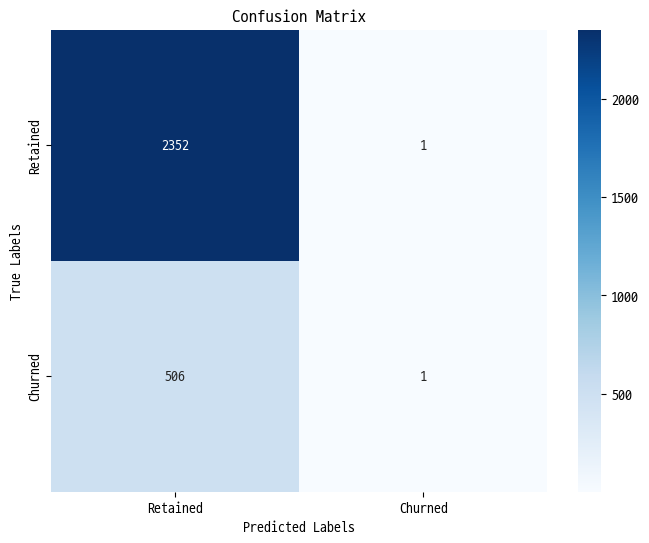

In [3]:
# 혼동 행렬 계산
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_list)


# 히트맵으로 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Retained", "Churned"],
    yticklabels=["Retained", "Churned"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

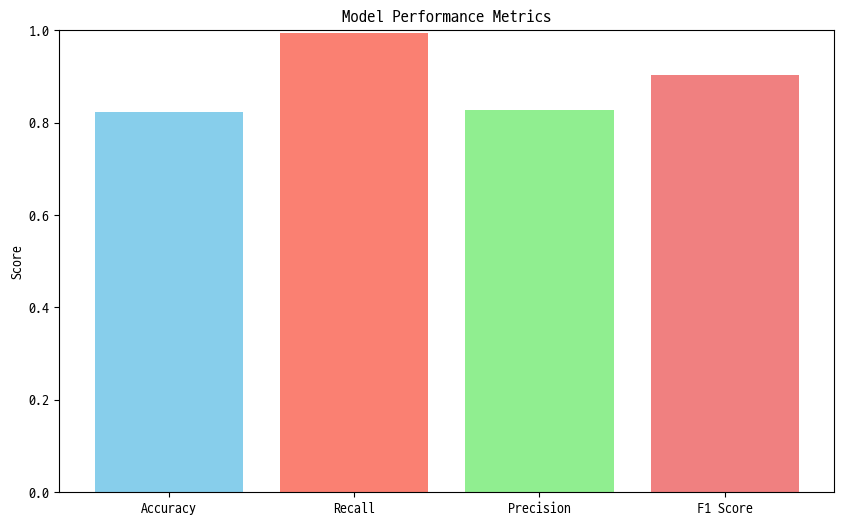

In [19]:
# 정확도, 재현율, 정밀도, F1 점수 시각화
metric = metrics["metric"]
values = metrics["value"]

plt.figure(figsize=(10, 6))
plt.bar(metric, values, color=["skyblue", "salmon", "lightgreen", "lightcoral"])
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.show()

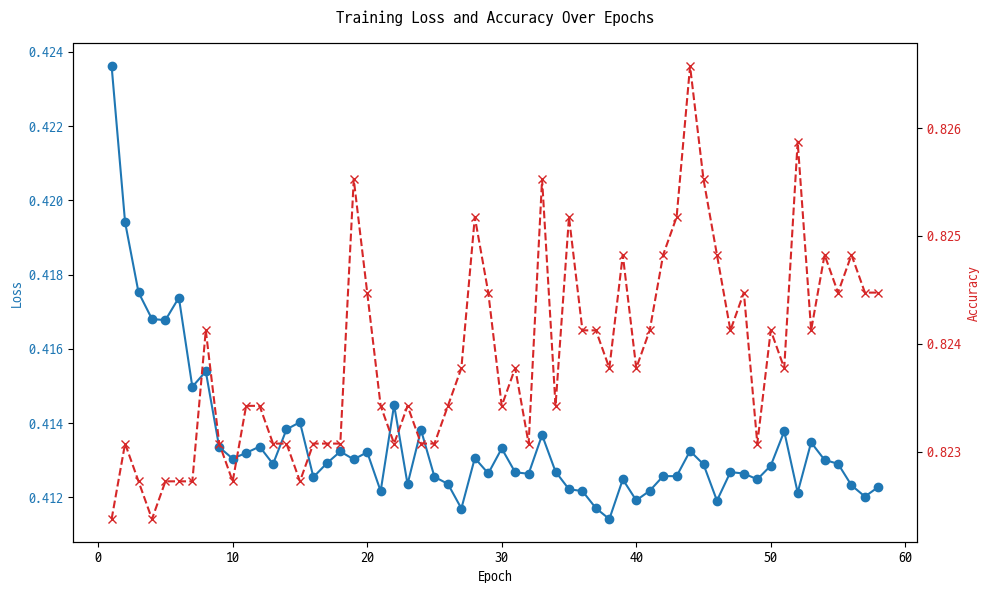

In [10]:
# 이중 y축 그래프: 학습 손실 및 정확도 변화 추세
fig, ax1 = plt.subplots(figsize=(10, 6))

# 손실 값 (왼쪽 y축)
color = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color)
ax1.plot(
    range(1, len(train_losses) + 1),
    valid_losses,
    color=color,
    marker="o",
    label="Train Loss",
)
ax1.tick_params(axis="y", labelcolor=color)

# 정확도 값 (오른쪽 y축)
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Accuracy", color=color)
ax2.plot(
    range(1, len(valid_acces) + 1),
    valid_acces,
    color=color,
    marker="x",
    linestyle="--",
    label="valid Accuracy",
)
ax2.tick_params(axis="y", labelcolor=color)

fig.suptitle("Training Loss and Accuracy Over Epochs")
fig.tight_layout()
plt.show()

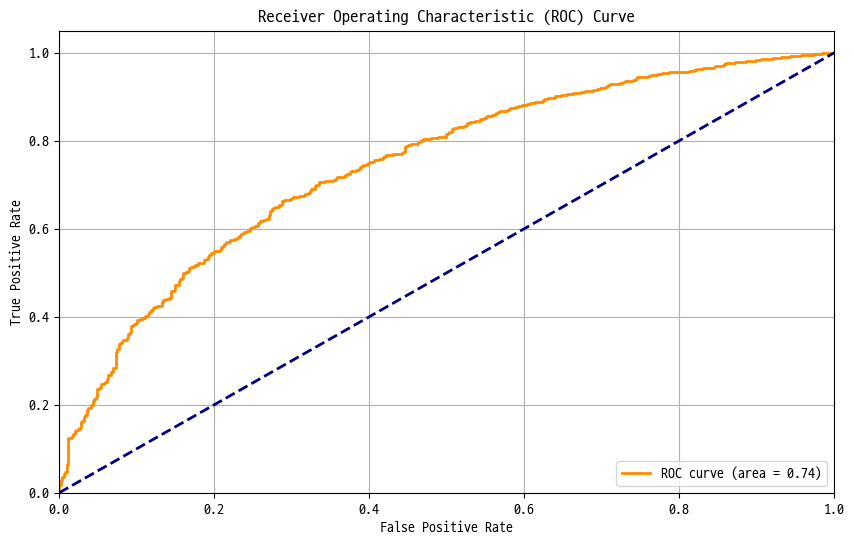

In [11]:
# ROC 곡선 및 AUC 계산
fpr = metrics["fpr"]
tpr = metrics["tpr"]
roc_auc = metrics["roc_auc"]

# ROC 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

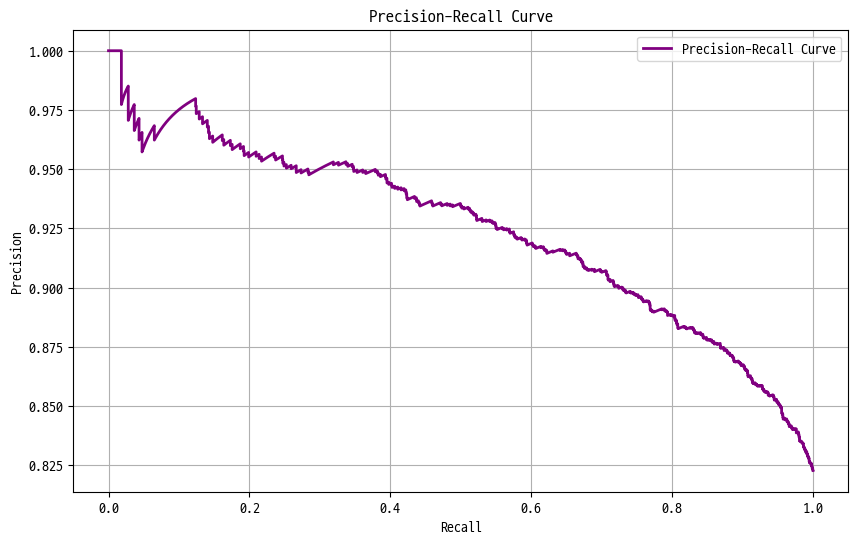

In [12]:
# Precision-Recall 곡선
precision = metrics["precision"]
recall = metrics["recall"]

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color="purple", lw=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid()
plt.show()

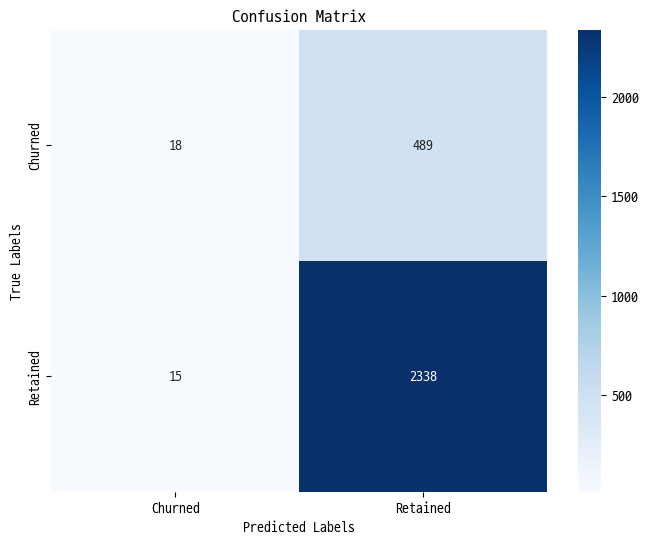

In [4]:
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred_list)


# 히트맵으로 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Churned", "Retained"],
    yticklabels=["Churned", "Retained"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [3]:
print(y_test)
print(y_pred_list)

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [1]]
tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)


In [ ]:
report = classification_report(y_test, y_pred_list)
print(report)

              precision    recall  f1-score   support

         0.0       0.67      0.01      0.02       507
         1.0       0.82      1.00      0.90      2353

    accuracy                           0.82      2860
   macro avg       0.75      0.51      0.46      2860
weighted avg       0.80      0.82      0.75      2860

